<a href="https://colab.research.google.com/github/benstream/CS-311/blob/main/AKFF_Data_Graphing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import geopandas as gpd
import glob
import os
from matplotlib import colormaps
import matplotlib.pyplot as plt
from datetime import datetime
import sys
import numpy as np

In [2]:
from google.colab import drive
from google.colab import data_table
data_table.enable_dataframe_formatter()
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Set Drive to directitory and make sure CSV files are there\
%cd /content/drive/Shareddrives/ISER_GINA/Bristol_Bay_Project/Historical\ Data/Fire_Weather_Data/akff_data

%ls

/content/drive/Shareddrives/ISER_GINA/Bristol_Bay_Project/Historical Data/Fire_Weather_Data/akff_data
akff_data_combined.csv             mesowest_psa10.csv   PAJZ_akff_data.csv
AKFF_Data_for_R.csv                missing_data/        PAKF_akff_data.csv
ALSA2_akff_data.csv                MOGA2_akff_data.csv  PANW_akff_data.csv
BLAA2_akff_data.csv                N15KX_akff_data.csv  PAPH_akff_data.csv
CONA2_akff_data.csv                N18KX_akff_data.csv  PAPN_akff_data.csv
COVA2_akff_data.csv                O14KX_akff_data.csv  PAPN_akff_data.gsheet
earliest_akff_data_by_station.csv  P17KX_akff_data.csv  PASD_akff_data.csv
FAFA2_akff_data.csv                PADL_akff_data.csv   station-availability02-16-2024.csv
FPKA2_akff_data.csv                PAIG_akff_data.csv   station-availability02-20-2024.csv
KILA2_akff_data.csv                PAIL_akff_data.csv   station-availability02-20-2024.xlsx
KILA2_akff_data.gsheet             PAJC_akff_data.csv   SVRA2_akff_data.csv


In [5]:
custom_intervals = [
    (1994, 1999),
    (2000, 2004),
    (2005, 2009),
    (2010, 2014),
    (2015, 2019),
    (2020, 2023)
]

# Define a function that returns zero if the value is negative, otherwise returns the value itself
def zero_if_negative(value):
    if value < 0:
        return 0
    else:
        return value

In [7]:
# Read in CSV File(s)
path = './' # use your path
# Some sort of station looping
all_files = glob.glob(os.path.join(path, "KILA2_akff_data.csv"))
df = pd.concat((pd.read_csv(f, comment='!',low_memory=False,usecols=['NAME','STATIONID','DATE','ATF','WSM','PREC','FWI','BUI','RHP'],parse_dates=['DATE']) for f in all_files), ignore_index=True)

# Create a list of months to filter (May-Sept)
months = [5, 6, 7, 8, 9]

# Combine files and sort by datetime, now data is ordered, removing rows that have no date, assigning dtypes.
#df['DATE'] = pd.to_datetime(df['DATE'],format = "%Y%m%d")
df.loc[:,'PREC'] = df.loc[:,'PREC'].to_numpy(float)
df.loc[:,'PREC'] = df['PREC'].apply(zero_if_negative)
df.loc[:,'WSM'] = df.loc[:,'WSM'].to_numpy(float)

# Calculate the rolling sum of the 'rain_diff' column with a window of 24 & 72 hours
df.loc[:,'day'] = df.loc[:,'DATE'].dt.dayofyear
df.loc[:,'year'] = df.loc[:,'DATE'].dt.year
df.loc[:,'rain_gain_24h'] = df.rolling('24H', on='DATE')['PREC'].sum()
df.loc[:,'rain_gain_72h'] = df.rolling('72H', on='DATE')['PREC'].sum()

# Grouping Data into 5 year increments
for start, end in custom_intervals:
    df.loc[(df['DATE'].dt.year >= start) & (df['DATE'].dt.year <= end), 'yearGroup'] = f"{start}-{end}"

yearRange = (1994,2023)

# Previously Set Variable
yearGroup = 'yearGroup'


# Filter the dataframe by the months after computations
df = df[df['DATE'].dt.month.isin(months)]

# Pivot the data by year and month
df_pivot = pd.pivot_table(df,index='day', columns=yearGroup, values='PREC').cumsum()

# Create Rolling Average for Max wind speed to pivot off of.
df_pivot_maxwind = pd.pivot_table(df,index='day', columns=yearGroup, values='WSM',aggfunc='max')
df_pivot_wind = pd.pivot_table(df,index='day', columns=yearGroup, values='WSM',aggfunc='mean')

# Create Rolling 72 Hour Average and Max wind speed
df.loc[:,'max_windspeed'] = df.rolling('3D', on='DATE')['WSM'].max()
df_pivot_maxwind_72hr = pd.pivot_table(df,index='day', columns=yearGroup, values='max_windspeed')

df.loc[:,'mean_windspeed_72hr'] = df.rolling('3D', on='DATE',min_periods=3)['WSM'].mean()
df_pivot_wind_72hr = pd.pivot_table(df,index='day', columns=yearGroup, values='mean_windspeed_72hr')

# Create the Pivots of rain averages
df_pivot_rain24hr = pd.pivot_table(df,index='day', columns=yearGroup, values='rain_gain_24h')
df_pivot_rain72hr = pd.pivot_table(df,index='day', columns=yearGroup, values='rain_gain_72h')

# # Create average of solar radiation ((DSR NOT DIRECT SOLAR RADIATION))
# df.loc[:,'mean_solar_rad_24hr'] = df.rolling('1D', on='DATE')['DSR'].mean()
# df_pivot_solar = pd.pivot_table(df,index='day', columns=yearGroup, values='mean_solar_rad_24hr')

# Create average and max of Build Up Index

df_pivot_bui_mean = pd.pivot_table(df,index='day', columns=yearGroup, values='BUI')
df_pivot_bui_max = pd.pivot_table(df,index='day', columns=yearGroup, values='BUI',aggfunc='max')

# Create average and max of solar radiation

df_pivot_fwi = pd.pivot_table(df,index='day', columns=yearGroup, values='FWI')
df_pivot_fwi_max = pd.pivot_table(df,index='day', columns=yearGroup, values='FWI', aggfunc='max')

# ATF Pivot Average and Max

df_pivot_atf = pd.pivot_table(df,index='day', columns=yearGroup, values='ATF')
df_pivot_atf_max = pd.pivot_table(df,index='day', columns=yearGroup, values='ATF', aggfunc='max')

# RHP Average and max
df_pivot_rhp = pd.pivot_table(df,index='day', columns=yearGroup, values='RHP')
df_pivot_rhp_max = pd.pivot_table(df,index='day', columns=yearGroup, values='RHP', aggfunc='max')



In [ ]:
# Yearly Plot Data

df_prec_yearly = pd.pivot_table(df,index='day', columns='year', values='PREC').cumsum()

# Create Rolling Average for Max wind speed to oivot off of.

df_maxwind_yearly = pd.pivot_table(df,index='day', columns='year', values='WSM',aggfunc='max')

df_wind_yearly = pd.pivot_table(df,index='day', columns='year', values='WSM',aggfunc='mean')

# Create Rolling 72 Hour Average and Max wind speed
df_maxwind_72hr_yearly = pd.pivot_table(df,index='day', columns='year', values='max_windspeed')

df_wind_72hr_yearly = pd.pivot_table(df,index='day', columns='year', values='mean_windspeed_72hr')

# Create the Pivots of rain averages
df_rain24hr_yearly = pd.pivot_table(df,index='day', columns='year', values='rain_gain_24h')
df_rain72hr_yearly = pd.pivot_table(df,index='day', columns='year', values='rain_gain_72h')

# # Create average of solar radiation ((DSR NOT DIRECT SOLAR RADIATION))
# df_solar_yearly = pd.pivot_table(df,index='day', columns='year', values='mean_solar_rad_24hr')

# Create average and max of Build Up Index

df_bui_mean_yearly = pd.pivot_table(df,index='day', columns='year', values='BUI')
df_bui_max_yearly = pd.pivot_table(df,index='day', columns='year', values='BUI',aggfunc='max')

# Create average and max of solar radiation

df_fwi_yearly = pd.pivot_table(df,index='day', columns='year', values='FWI')
df_fwi_max_yearly = pd.pivot_table(df,index='day', columns='year', values='FWI', aggfunc='max')

# Create average and max of Air Temp Fairenheit

df_atf_yearly = pd.pivot_table(df,index='day', columns='year', values='ATF')
df_atf_max_yearly = pd.pivot_table(df,index='day', columns='year', values='ATF', aggfunc='max')

In [8]:
figsize=(16, 8)
nameID = (df.iloc[0].NAME,df.iloc[0].STATIONID)
columns = 2
lw = 3
colormap = 'plasma'
# Manual Declaration of All "Expected" Years
yearLabelsManual = ['1994-1999', '2000-2004', '2005-2009', '2010-2014', '2015-2019', '2020-2023']
cmap = plt.get_cmap(colormap)
colors = [cmap(i / len(custom_intervals)) for i in range(len(custom_intervals))]
color_dict = dict(zip(yearLabelsManual, colors))

coloring_scheme = [color_dict.get(period) for period in df['yearGroup'].unique() ]


In [ ]:
# Yearly Plots (Messy!)
# BUI Yearly Plots
df_bui_mean_yearly.plot(lw=lw,colormap=colormap,ylabel='BUI',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): Average Build Up Index Yearly",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(ncol = columns)

#FWI Yearly Plts
# FWI Plots, Max and Average
# Average FWI Plot
df_fwi_yearly.plot(lw=lw,colormap=colormap,ylabel='FWI',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): Average Fire Weather Index Yearly",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(ncol = columns)

# Yearly Precip Plot
df_prec_yearly.plot(lw=3,colormap=colormap,ylabel='Precipitation (in)',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): Accumulated Precipitation Yearly",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(loc="upper left", ncol = columns)

# 24 and 72 Hour Precip Yearly

df_rain72hr_yearly.plot(lw=lw,colormap=colormap,ylabel='Precipitation (in)',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): 72 Hour Precipitation Yearly",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(loc="upper left", ncol = columns)
df_rain24hr_yearly.plot(lw=lw,colormap=colormap,ylabel='Precipitation (in)',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): 24 Hour Precipitation Yearly",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(loc="upper left", ncol = columns)

# Windspeeds 24 Hours, Yearly

# 24 Hour Max and Average windspeed
df_wind_yearly.plot(lw=lw,colormap=colormap,ylabel='Windspeed (MPH)',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): 24 Hour Average Wind Speed Yearly",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(loc="upper left", ncol = columns)
# Windspeeds 72 Hours, Yearly

# 72 Hour Rolling Averages and Maxes.
df_wind_72hr_yearly.plot(lw=lw,colormap=colormap,ylabel='Windspeed (MPH)',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): 72 Hour Average Wind Speed Yearly",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(loc="upper left", ncol = columns)
df_maxwind_72hr_yearly.plot(lw=lw,colormap=colormap,ylabel='Windspeed (MPH)',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): 72 Hour Max Wind Speed Yearly",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(loc="upper left", ncol = columns)

# ATF Yearly
df_atf_max_yearly.plot(lw=lw,colormap=colormap,ylabel='Air Temp F',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): Air Temperature Yearly",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(loc="upper left", ncol = columns)
df_atf_yearly.plot(lw=lw,colormap=colormap,ylabel='Air Temp F',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): Max Air Temperature Yearly",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(loc="upper left", ncol = columns)


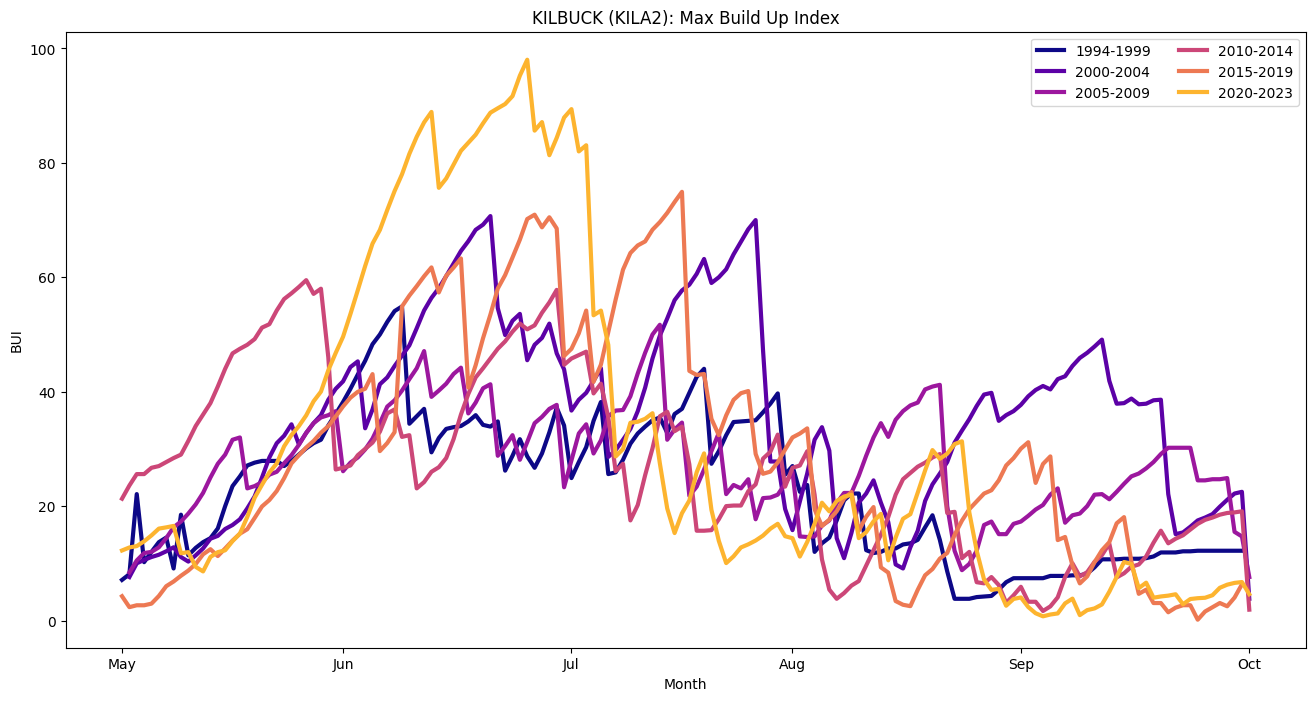

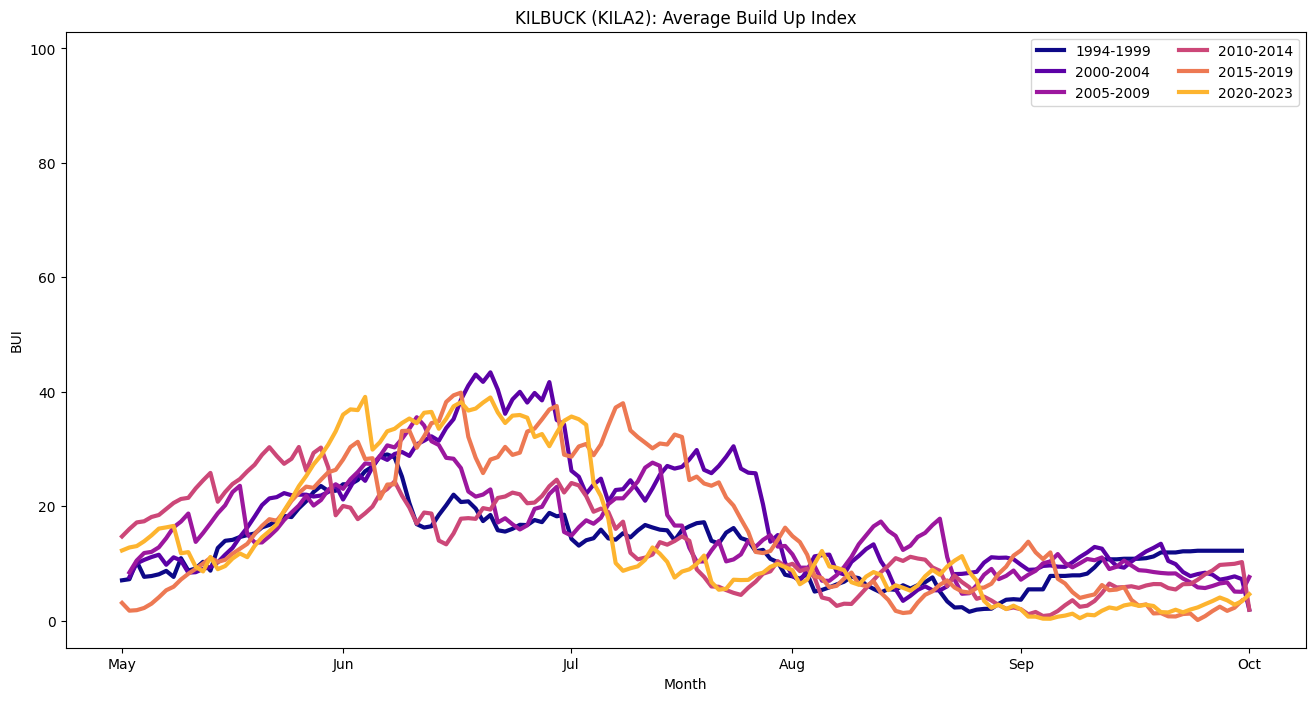

In [ ]:
# Build Up Index Plots, max and Average
# Max Plot
df_pivot_bui_max.plot(lw=lw,color=coloring_scheme,ylabel='BUI',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): Max Build Up Index",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend( ncol = columns)
ylim=plt.ylim()
# Average Plot
df_pivot_bui_mean.plot(lw=lw,color=coloring_scheme,ylabel='BUI',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): Average Build Up Index",figsize=figsize,ylim=ylim)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend( ncol = columns)

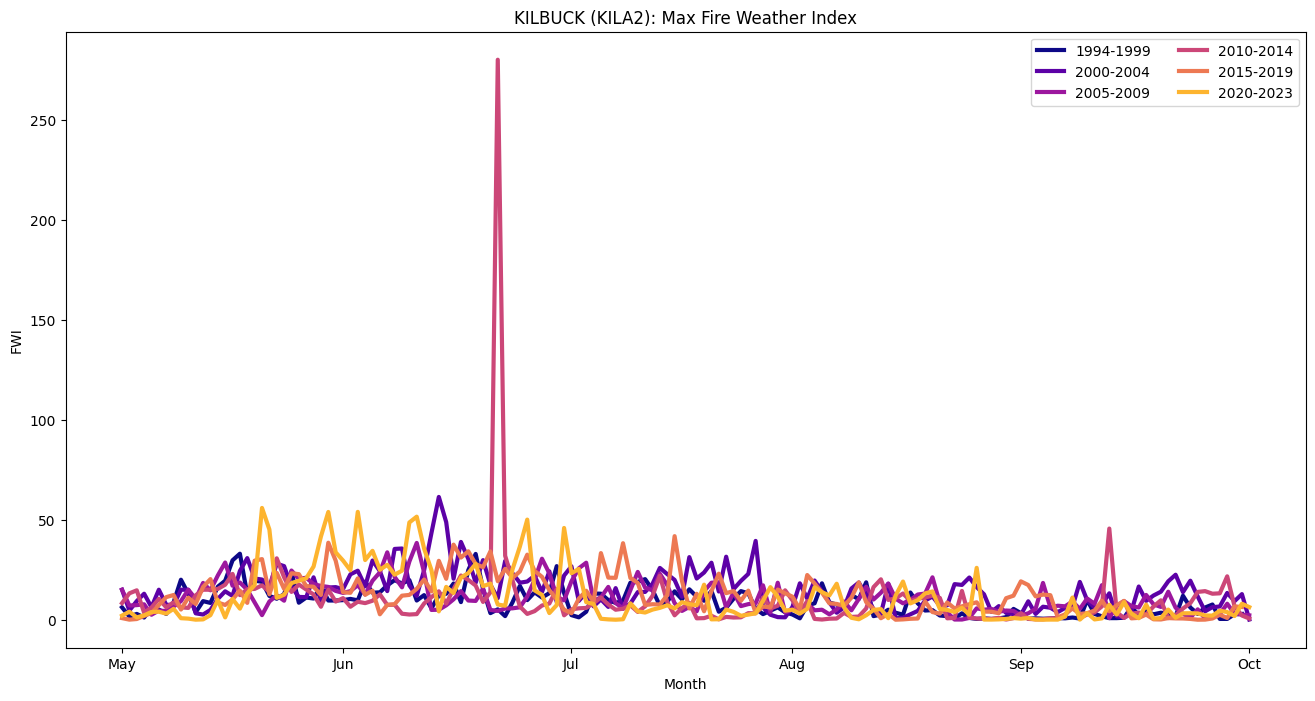

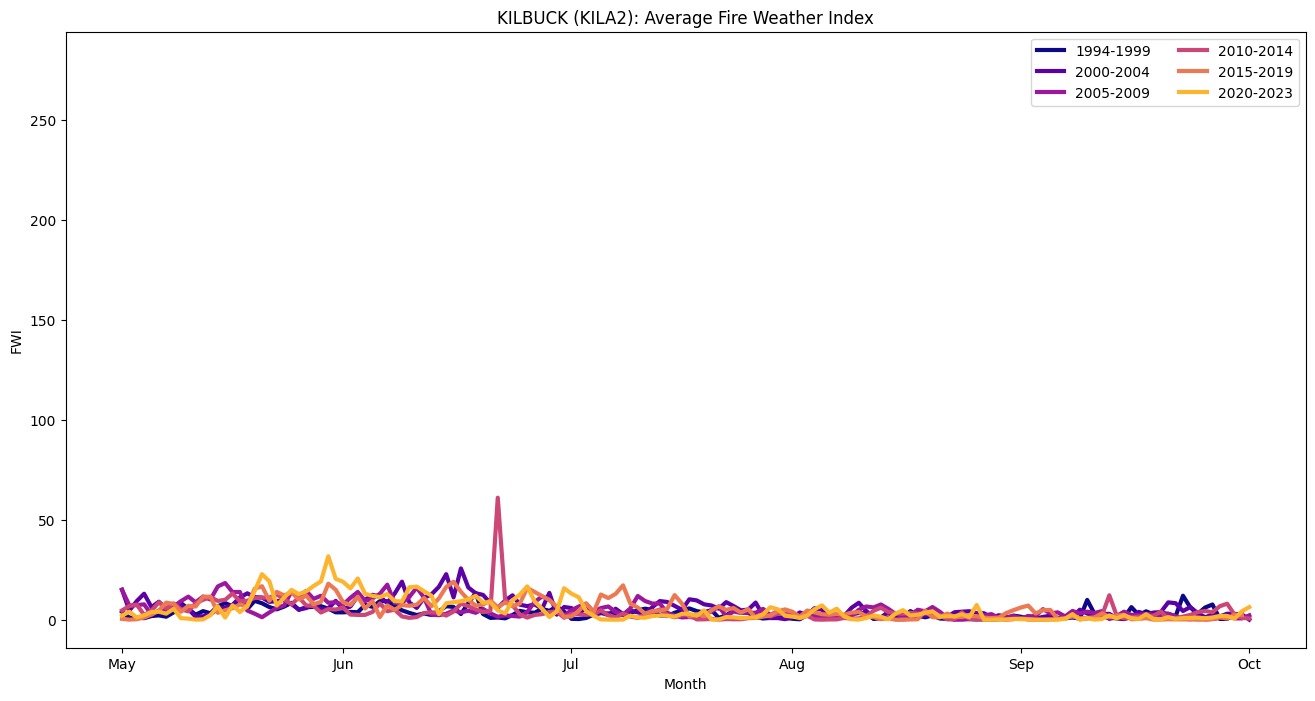

In [ ]:
# FWI Plots, Max and Average
# Max FWI Plot
df_pivot_fwi_max.plot(lw=lw,color=coloring_scheme,ylabel='FWI',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): Max Fire Weather Index",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend( ncol = columns)
ylim = plt.ylim()

# Average FWI Plot
df_pivot_fwi.plot(lw=lw,color=coloring_scheme,ylabel='FWI',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): Average Fire Weather Index",figsize=figsize,ylim=ylim)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend( ncol = columns)

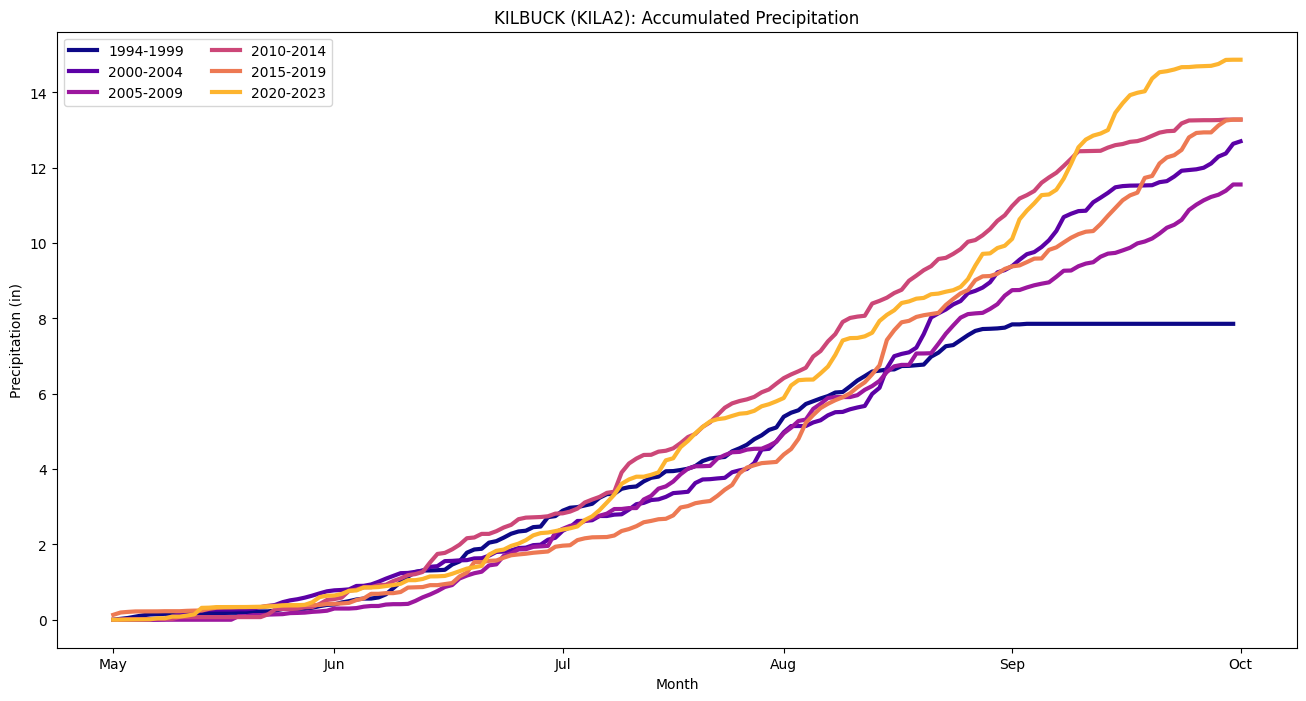

In [ ]:
# Accumulated Precipitation Plot, When no data, stop graphing.
df_pivot.plot(lw=3,color=coloring_scheme,ylabel='Precipitation (in)',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): Accumulated Precipitation",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(loc="upper left", ncol = columns)

In [ ]:
# df_pivot_solar.plot(lw=lw,color=coloring_scheme,ylabel='Solar Radiation (W/m**2)',xlabel='Month',legend='reverse',title="Average Solar Radiation",figsize=figsize)
# plt.xticks(np.linspace(121,274,6)[:-1], ('May','Jun','Jul','Aug','Sep'))
# plt.legend(loc="upper left", ncol = columns)

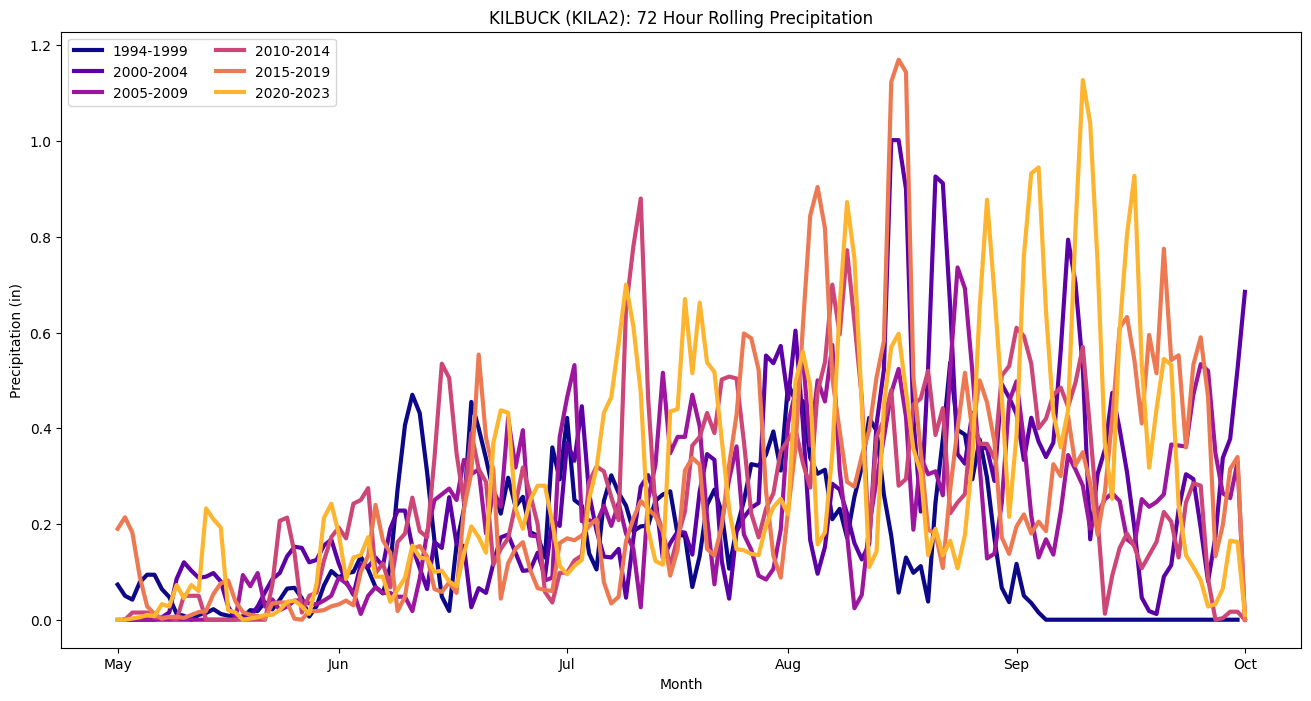

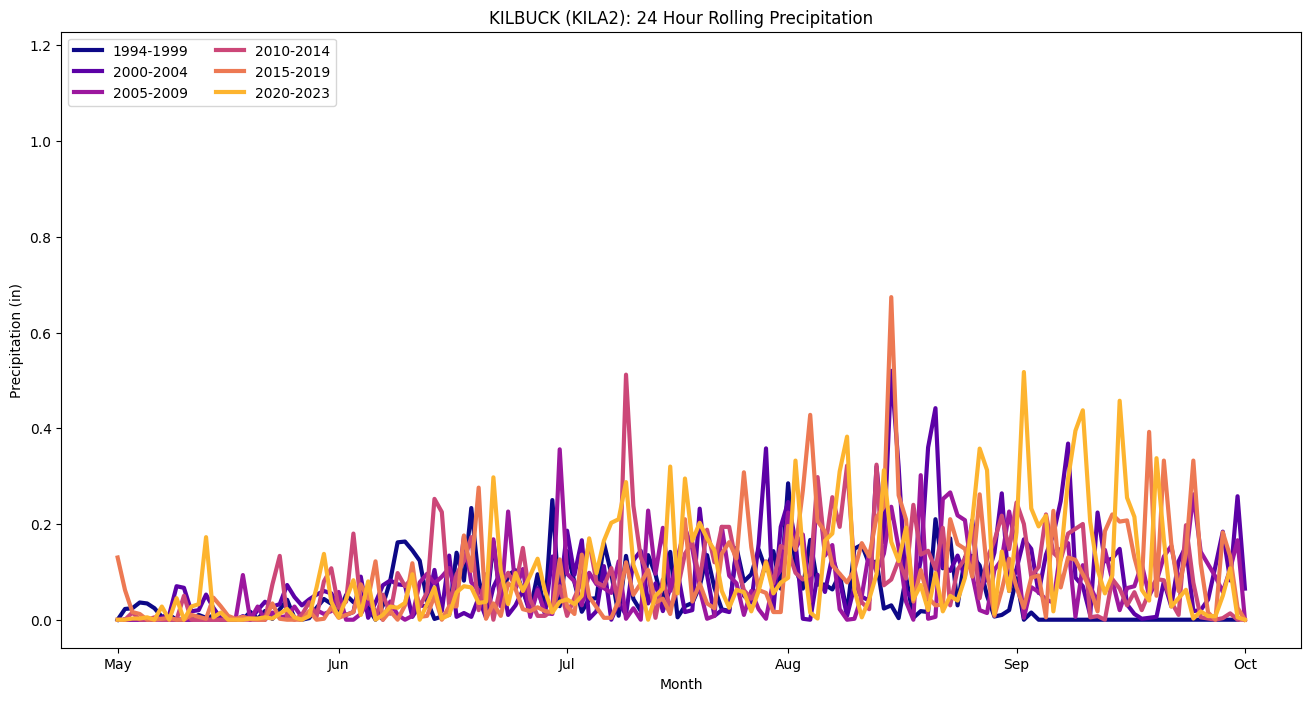

In [ ]:
df_pivot_rain72hr.plot(lw=lw,color=coloring_scheme,ylabel='Precipitation (in)',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): 72 Hour Rolling Precipitation",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(loc="upper left", ncol = columns)

ylim = plt.ylim()

df_pivot_rain24hr.plot(lw=lw,color=coloring_scheme,ylabel='Precipitation (in)',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): 24 Hour Rolling Precipitation",figsize=figsize, ylim=ylim)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(loc="upper left", ncol = columns)

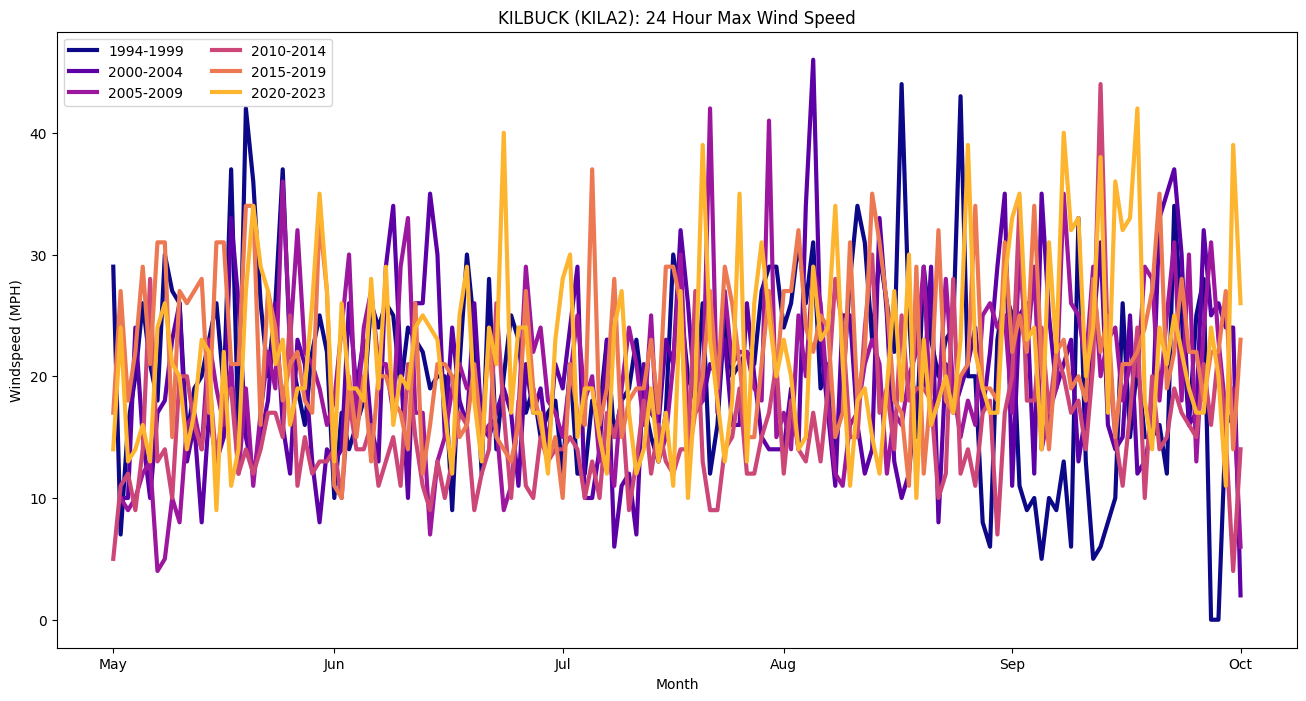

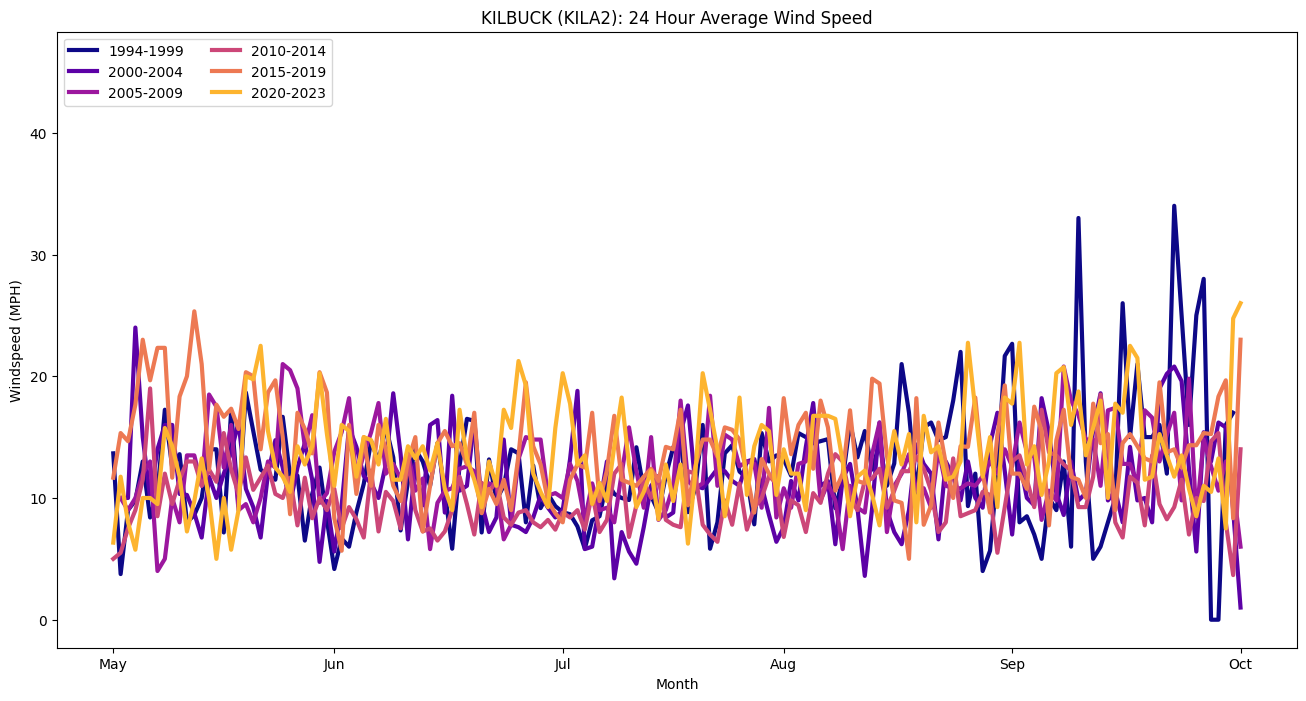

In [ ]:
# 24 Hour Max and Average windspeed
df_pivot_maxwind.plot(lw=lw,color=coloring_scheme,ylabel='Windspeed (MPH)',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): 24 Hour Max Wind Speed",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(loc="upper left", ncol = columns)

ylim = plt.ylim()

df_pivot_wind.plot(lw=lw,color=coloring_scheme,ylabel='Windspeed (MPH)',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): 24 Hour Average Wind Speed",figsize=figsize,ylim=ylim)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(loc="upper left", ncol = columns)

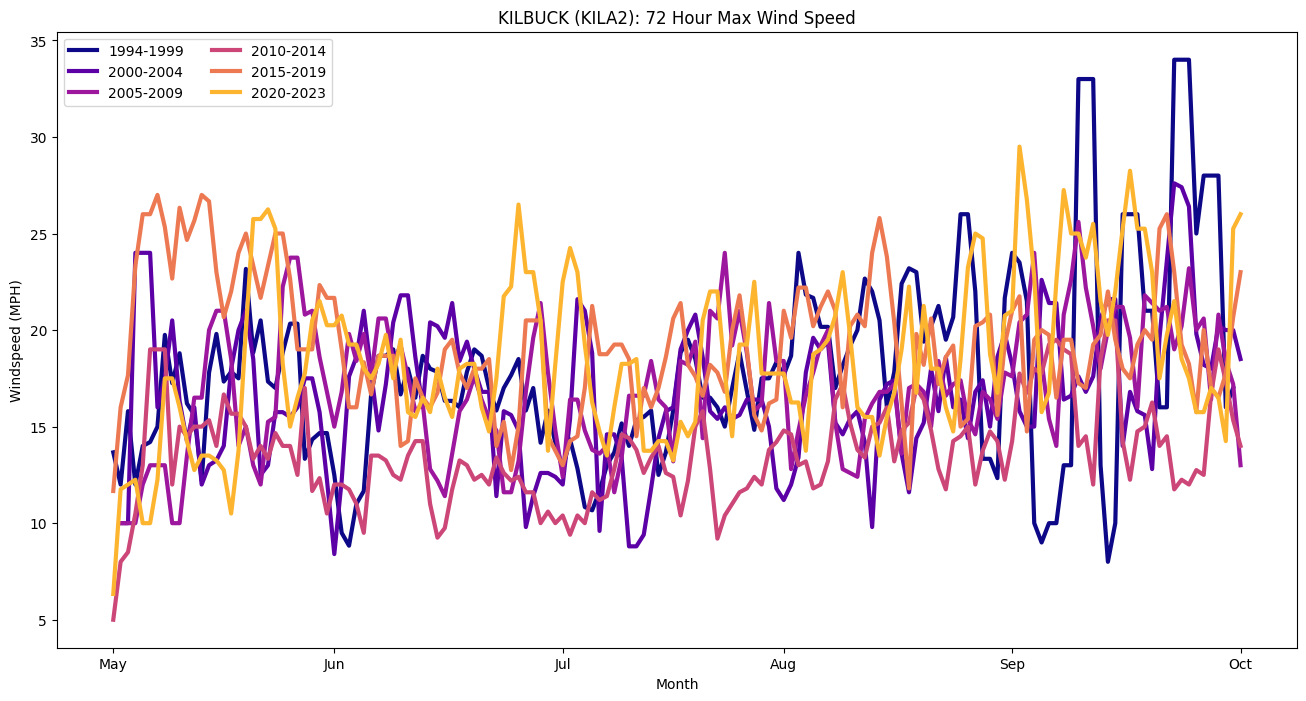

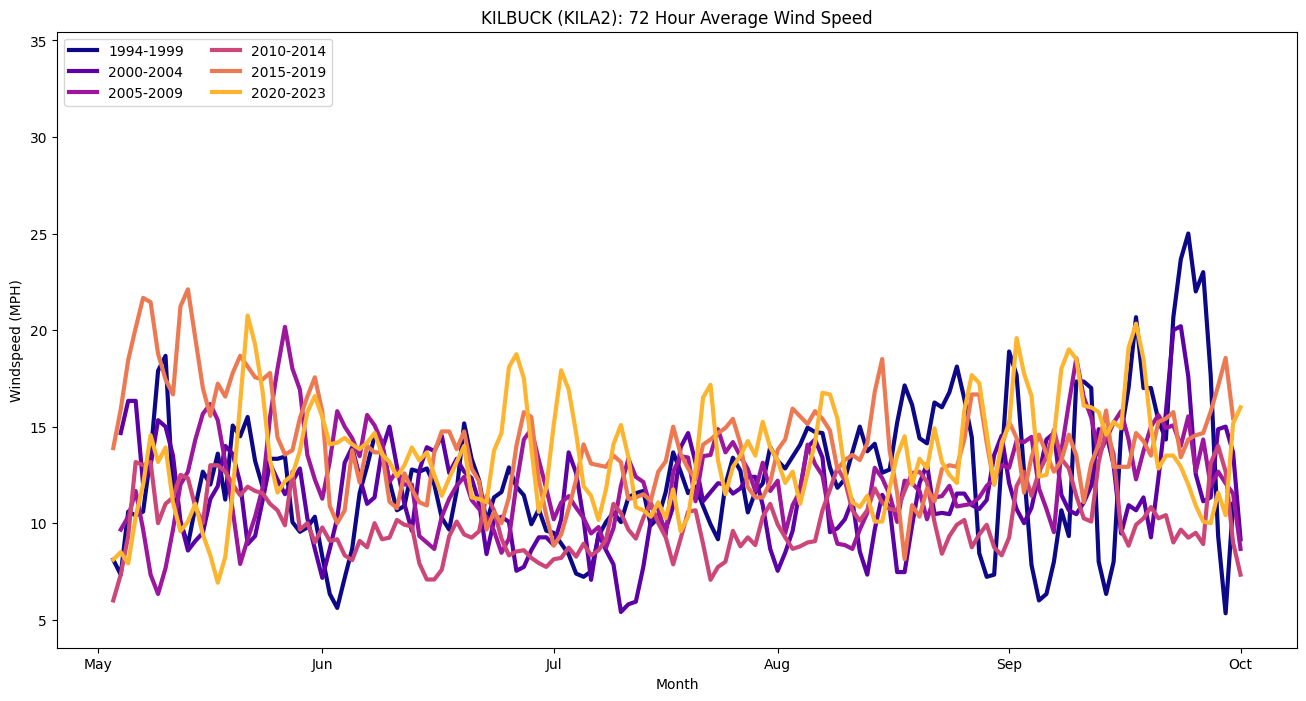

In [ ]:
# 72 Hour Rolling Averages and Maxes.
df_pivot_maxwind_72hr.plot(lw=lw,color=coloring_scheme,ylabel='Windspeed (MPH)',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): 72 Hour Max Wind Speed",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(loc="upper left", ncol = columns)
ylim = plt.ylim()
df_pivot_wind_72hr.plot(lw=lw,color=coloring_scheme,ylabel='Windspeed (MPH)',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): 72 Hour Average Wind Speed",figsize=figsize,ylim=ylim)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(loc="upper left", ncol = columns)

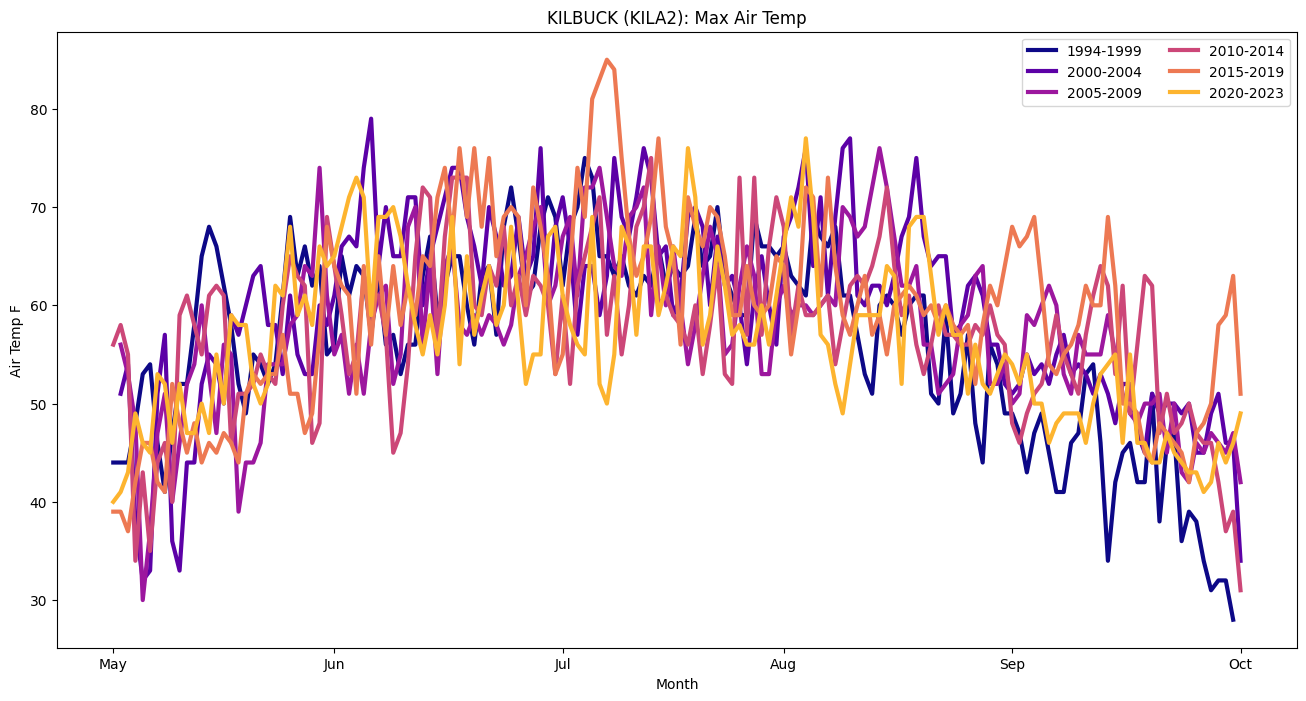

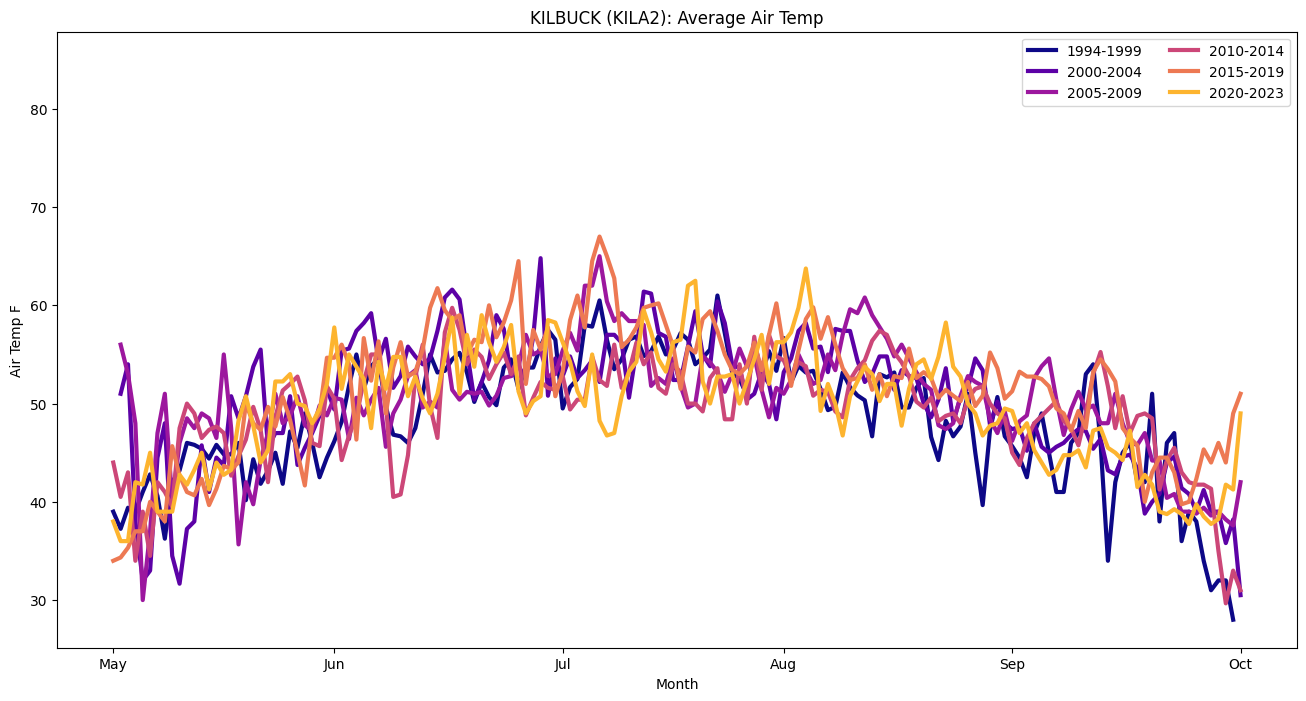

In [ ]:
# ATF Plots, Max and Average
# Max ATF Plot
df_pivot_atf_max.plot(lw=lw,color=coloring_scheme,ylabel='Air Temp F',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): Max Air Temp",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend( ncol = columns)

ylim = plt.ylim()
# Average ATF Plot
df_pivot_atf.plot(lw=lw,color=coloring_scheme,ylabel='Air Temp F',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): Average Air Temp",figsize=figsize,ylim=ylim)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend( ncol = columns)

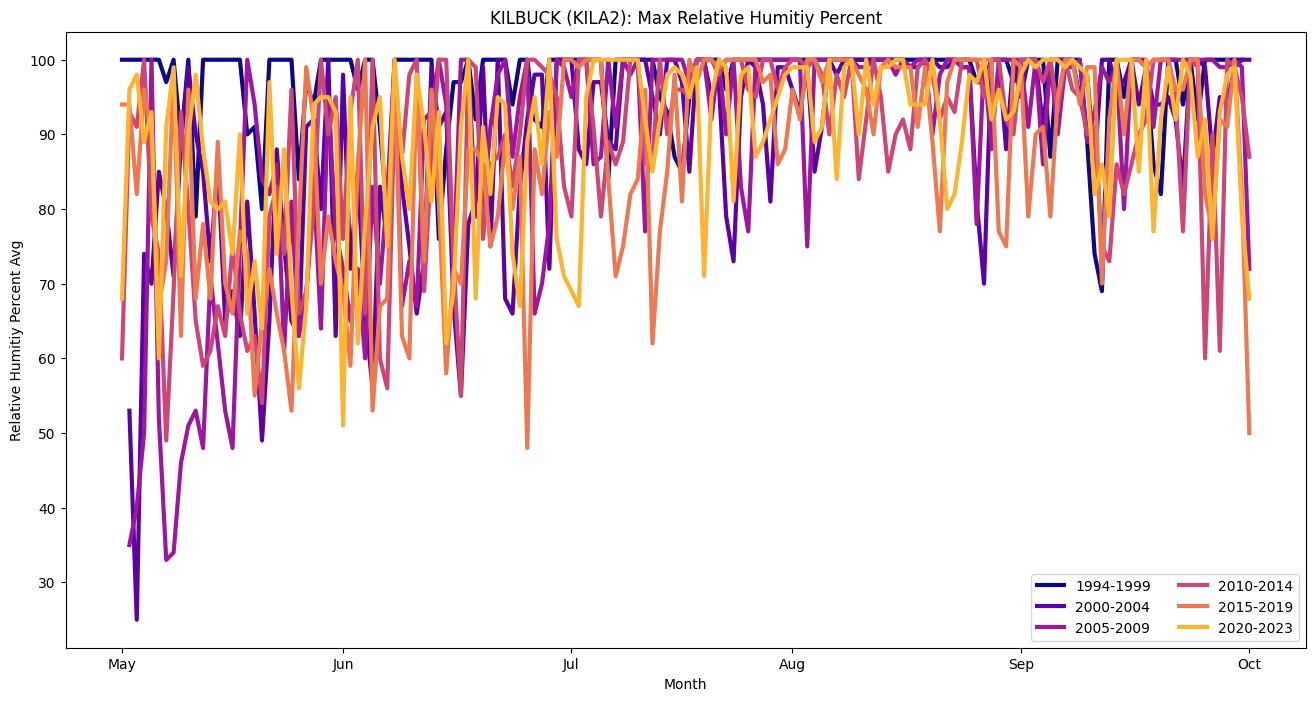

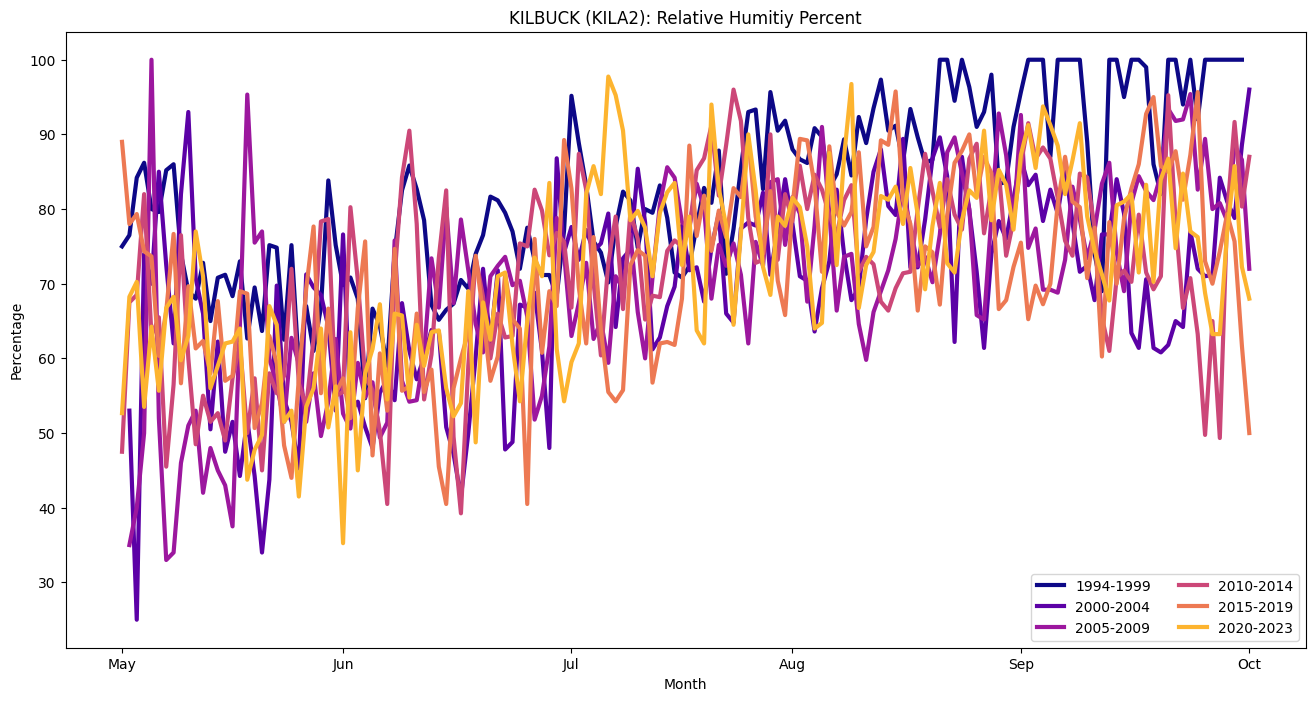

In [ ]:
# Humidity Graphs RHP
# Max RHP Plot
df_pivot_rhp_max.plot(lw=lw,color=coloring_scheme,ylabel='Relative Humitiy Percent Avg',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): Max Relative Humitiy Percent",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend( ncol = columns)

ylim = plt.ylim()

# Average RPH Plot
df_pivot_rhp.plot(lw=lw,color=coloring_scheme,ylabel='Percentage',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): Relative Humitiy Percent",figsize=figsize,ylim=ylim)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend( ncol = columns)